# GTRSB - Warning sign detection using CNN


This notebook focuses on the classification of traffic signs using deep learning, specifically a Convolutional Neural Network (CNN).

Traffic sign recognition is a crucial task for autonomous driving and driver assistance systems, enabling vehicles to interpret road signs in real-time.

The dataset used is the German Traffic Sign Recognition Benchmark (GTSRB), which contains various sign categories under different lighting and weather conditions. The images are preprocessed and augmented to improve model robustness. A CNN architecture is then implemented and trained to accurately classify traffic signs, aiming for high generalization across diverse real-world scenarios.

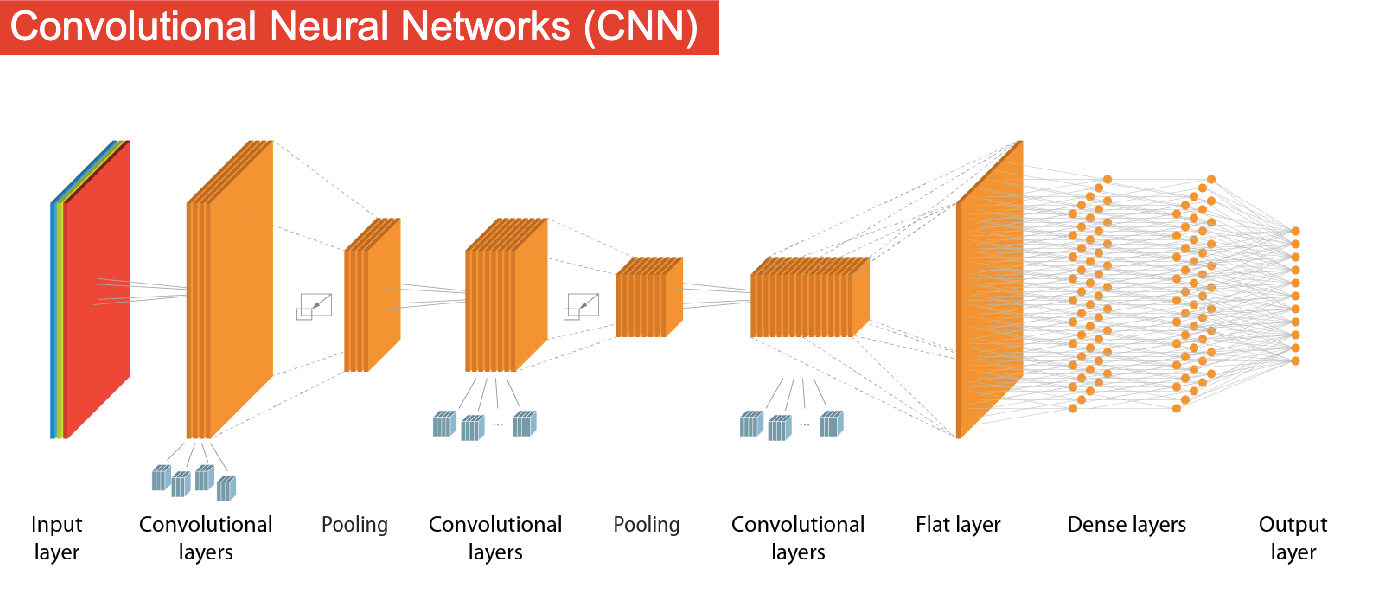

In [2]:
import pandas as pd
import h5py
import numpy as np
import math, random
from importlib import reload
import matplotlib.pyplot as plt
import os

from io import BytesIO
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

splits = {'train': 'data/train-00000-of-00001-dc762c064c221993.parquet'}
data = pd.read_parquet("hf://datasets/bazyl/GTSRB/" + splits["train"])
data = data.sample(frac = 1).reset_index(drop = True)
print(data.shape)
data.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,26,28,5,6,21,23,3,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
1,63,63,5,5,58,58,40,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
2,115,116,10,10,105,106,9,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
3,30,30,6,6,25,25,38,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...
4,52,53,6,6,47,48,37,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...


In [3]:
# Create a list of images array
IMG_SIZE = (28, 28)

image_list = []

for i in range(len(data)):
    image_bytes = data.iloc[i]["Path"]["bytes"]
    img = Image.open(BytesIO(image_bytes))
    img = img.resize(IMG_SIZE)
    img_array = np.array(img) / 255.0
    image_list.append(img_array)

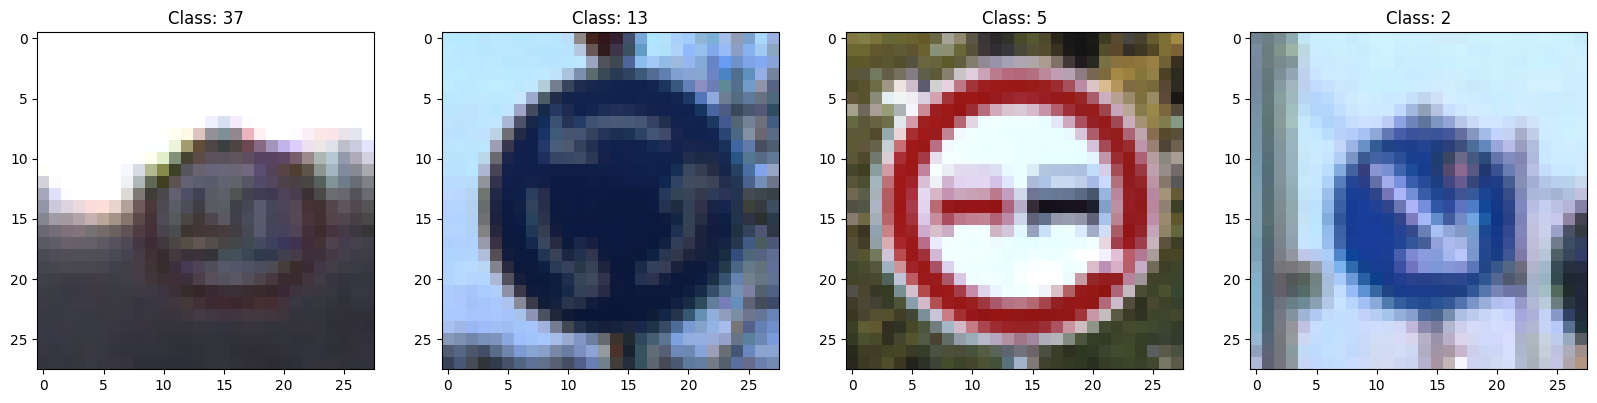

In [50]:
# Plotting data
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20, 5))

lst_plot = image_list[:4]
label = list(data.ClassId.iloc[:4])

for i in range(len(lst_plot)):
  axes[i].imshow(np.array(image_list[i]))
  axes[i].set_title(f'Class: {label[i]}')

plt.show()

In [4]:
# Splitting data into Train, Valid & Test set

SPLIT = int(0.7 * len(image_list))

X_train = np.array(image_list[:SPLIT])
X_valid = np.array(image_list[SPLIT:])

y_train = np.array(data.ClassId[:SPLIT])
y_valid = np.array(data.ClassId[SPLIT:])

SPLIT_TEST = int(0.05 * len(X_valid))

x_test = np.array(X_valid[SPLIT_TEST:])
y_test = np.array(y_valid[SPLIT_TEST:])

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((27446, 28, 28, 3),
 (27446,),
 (11763, 28, 28, 3),
 (11763,),
 (9411, 28, 28, 3),
 (9411,))

In [5]:
# Building CNN Architecture model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, Input, Dropout

model = Sequential()
model.add(Input(shape = (28, 28, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dense(units = 43, activation = 'sigmoid'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,203 (2.95 MB)

 Trainable params: 772,203 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = SparseCategoricalCrossentropy(),
              metrics = ['Accuracy'])

In [7]:
history = model.fit(X_train,
          y_train,
          epochs = 15,
          validation_data = (X_valid, y_valid),
          batch_size = 16)

Epoch 1/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - Accuracy: 0.2684 - loss: 2.5296 - val_Accuracy: 0.8082 - val_loss: 0.5883
Epoch 2/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - Accuracy: 0.7178 - loss: 0.8071 - val_Accuracy: 0.9065 - val_loss: 0.2833
Epoch 3/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Accuracy: 0.8089 - loss: 0.5378 - val_Accuracy: 0.9467 - val_loss: 0.1584
Epoch 4/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - Accuracy: 0.8401 - loss: 0.4427 - val_Accuracy: 0.9666 - val_loss: 0.1112
Epoch 5/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - Accuracy: 0.8754 - loss: 0.3433 - val_Accuracy: 0.9564 - val_loss: 0.1025
Epoch 6/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - Accuracy: 0.8833 - loss: 0.3154 - val_Accuracy: 0.9652 - val_loss: 0.0831
Epoch 7/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - Accuracy: 0.8936 - loss: 0.3034 - val_Accuracy: 0.9753 - val_loss: 0.0708
Epoch 8/15
1716/1716 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - Accuracy: 0.9009 - loss: 0.281

368/368 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Accuracy: 0.9875 - loss: 0.0438
Score: [0.0406622588634491, 0.988693356513977]


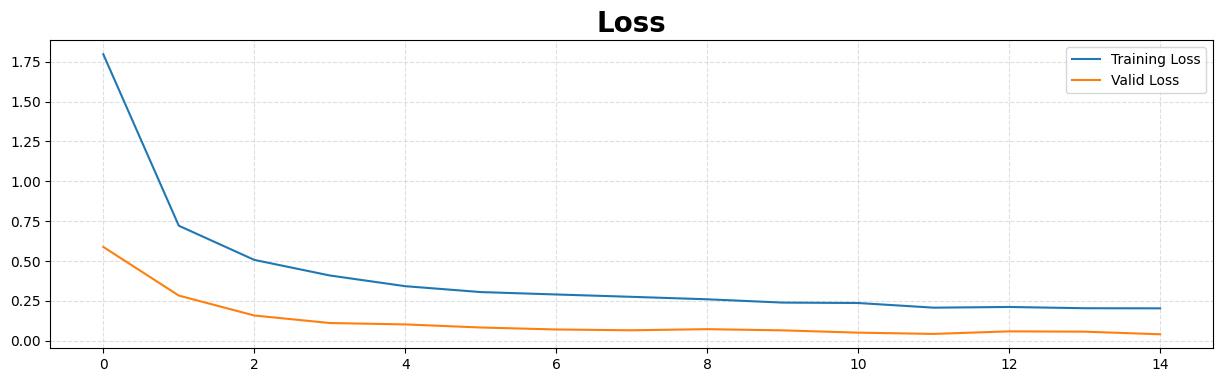

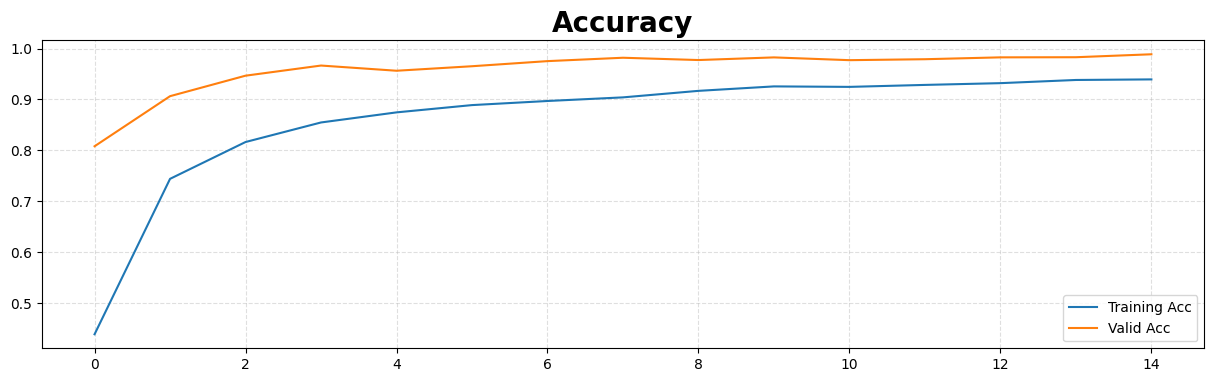

In [42]:
score = model.evaluate(X_valid, y_valid)
print(f'Score: {score}')

plt.figure(figsize = (15, 4))
plt.plot(history.epoch, history.history['loss'], label = 'Training Loss')
plt.plot(history.epoch, history.history['val_loss'], label = 'Valid Loss')
plt.title('Loss', fontsize = 20, fontweight = 'bold')
plt.grid(True, ls = '--', alpha = 0.4)
plt.legend()
plt.show()

print()

plt.figure(figsize = (15, 4))
plt.plot(history.epoch, history.history['Accuracy'], label = 'Training Acc')
plt.plot(history.epoch, history.history['val_Accuracy'], label = 'Valid Acc')
plt.title('Accuracy', fontsize = 20, fontweight = 'bold')
plt.grid(True, ls = '--', alpha = 0.4)
plt.legend()
plt.show()

## Testing On new data

In [35]:
model.evaluate(x_test, y_test)

295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Accuracy: 0.9902 - loss: 0.0382


[0.03870818018913269, 0.9895866513252258]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


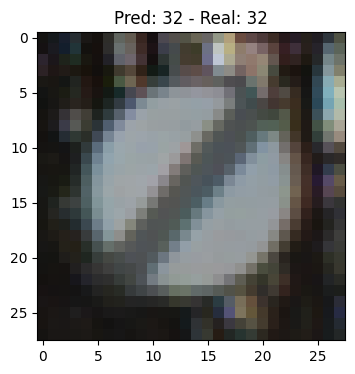

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


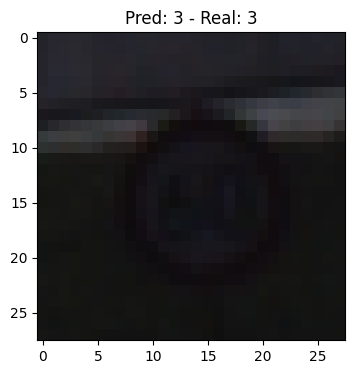

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


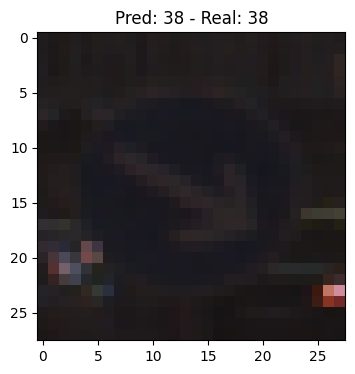

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


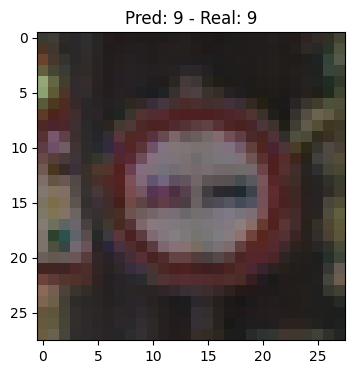

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


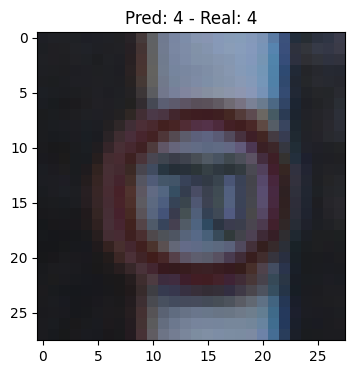

In [28]:
start = np.random.randint(len(x_test))

for i in range(start, start + 5, 1):
  test_data, label = x_test[i], y_test[i]
  test_data_dim = np.reshape(test_data, (1, 28, 28, 3))
  pred = np.argmax(model.predict(test_data_dim))

  plt.figure(figsize = (5, 4))
  plt.imshow(test_data)
  plt.title(f'Pred: {pred} - Real: {label}')
  plt.show()
